Выполнил: Кагарманов Эрик  
Data scientist  
Контакт: +7 912 599 15 25   
mail: kagarmanov.science@gmail.com  
telegram: https://t.me/erikkagarmanov  

# Описание задачи и входных значений

«Прогнозирование оттока пользователей интернет-провайдера»  
  
Создать решение по прогнозированию оттока с использованием данных о клиентах.   
В вашем доступе находится информация о запросах пользователей к сайтам конкурентов и история обращений в компанию.   
Не использовать contract_id как фичу.  

Описание входных значений 

●	train.csv — файл содержащий данные пользователей для тренировки. где:   
○	1 - клиент ушел,     
○	0 - остался (может сокращаться в xlsx файле)  
●	log.csv — содержит данные обращения пользователей.;   
●	named.csv — лог днс-запросов к доменам конкурентов (rt.ru и sampo.ru).   
●	type contract.csv - тип списания у пользователей, где:   
○	1 - посуточная,   
○	0 - помесячная.  
●	sample_solution.csv — пример файла для отправки  


# Imports

In [1]:
# работа с данными
import numpy as np 
import pandas as pd

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns 

# метрики
from sklearn.metrics import f1_score, recall_score, precision_score

# алгоритмы машинного ообучения
from lightgbm import LGBMClassifier

# кросс-валидация
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold

# предобработка и преобразование текстовых признаков
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import RussianStemmer

# от предупреждений 
import warnings
warnings.simplefilter("ignore")

# фиксиурем рандом
random_state = 142

# Описание функций

In [2]:
def cl_fs(
    cl, cl_helper, X_train, y_train, 
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    """ Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации """

    temp_features = features
    new_feats = []

    for p in ps:

        cl_helper.fit(X_train[temp_features], y_train)

        imp = pd.Series(data = cl_helper.feature_importances_, index = temp_features)

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        # print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test

# Загрузка и обзор данных

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
train

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0
...,...,...
5987,274601,1
5988,274710,1
5989,274782,1
5990,274786,1


In [5]:
train.nunique()

contract_id    5992
blocked           2
dtype: int64

In [6]:
log = pd.read_csv('data/log.csv')

In [7]:
log

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах
...,...,...,...
25269,11801,2021-04-29 07:50:44,Информер ВК. Показ
25270,54405,2021-03-17 10:38:42,Информер ВК. Показ
25271,54405,2021-03-23 08:21:29,Информер ВК. Показ
25272,54405,2021-04-09 13:04:26,Информер ВК. Показ


In [8]:
log.nunique()

contract_id     4311
event_date     24906
event_type       105
dtype: int64

In [9]:
named = pd.read_csv('data/named.csv')

In [10]:
named

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335
3,17-Apr-2021,tvip-provision.sampo.ru,61670
4,17-Apr-2021,tvip-provision.sampo.ru,39370
...,...,...,...
10646532,01-Apr-2021,_sip._udp.048056.16.rt.ru,164026
10646533,01-Apr-2021,048056.16.rt.ru,133945
10646534,01-Apr-2021,camera.rt.ru,67986
10646535,01-Apr-2021,camera.rt.ru,31576


In [11]:
named.nunique()

date               36
url              6583
contract_id    196148
dtype: int64

In [12]:
type_contract = pd.read_csv('data/type_contract.csv')

In [13]:
type_contract

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0
3,7794,0
4,7795,1
...,...,...
6800,3503,1
6801,3589,0
6802,4261,0
6803,4118,1


In [14]:
type_contract.nunique()

contract_id              6800
day_or_month_contract       2
dtype: int64

In [15]:
sample_solution = pd.read_csv('data/sample_solution.csv')

In [16]:
sample_solution

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,0


In [17]:
sample_solution.nunique()

contract_id    810
blocked          1
dtype: int64

# Формирование датасета и создание признаков

Выберем контракты, которые будут участвовать в обучении и тестировании (предсказании).

In [18]:
train_contract_ids = (train.contract_id).values
test_contract_ids = (sample_solution.contract_id).values
contract_ids = np.append(train_contract_ids, test_contract_ids)

Сформируем базовый дата фрейм.  
Объеденим:  
- train,  
- sample_submission (id контрактов),  
- type_contract

In [19]:
type_contract

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0
3,7794,0
4,7795,1
...,...,...
6800,3503,1
6801,3589,0
6802,4261,0
6803,4118,1


In [20]:
df = pd.concat([train, pd.DataFrame(data = test_contract_ids, columns=['contract_id'])]).reset_index(drop = True)
df = df.merge(type_contract, on = 'contract_id', how = 'left').drop_duplicates().reset_index(drop = True)
df['test'] = np.where(df['blocked'] >= 0, 0, 1)
df

,contract_id,blocked,day_or_month_contract,test
0,7780,0.0,0.0,0
1,7785,0.0,0.0,0
2,7794,0.0,0.0,0
3,7795,0.0,1.0,0
4,7798,0.0,0.0,0
...,...,...,...,...
6797,4258,NaN,1.0,1
6798,4259,NaN,1.0,1
6799,4260,NaN,0.0,1
6800,4261,NaN,0.0,1


In [21]:
df.nunique()

contract_id              6802
blocked                     2
day_or_month_contract       2
test                        2
dtype: int64

## Named features

Для каждого клиента сформируем признаки, основанные на истории его логов посещения сторонних сайтов

In [22]:
named_2 = named[named.contract_id.isin(contract_ids)]

In [23]:
named_2['date'] = named_2['date'].apply(pd.to_datetime)
named_2['date_unixtimestamp'] = (named_2['date']).apply(lambda x: x.timestamp())
named_2['date_year'] = (named_2['date']).apply(lambda x: x.year)
named_2['date_month'] = (named_2['date']).apply(lambda x: x.month)
named_2['date_day'] = (named_2['date']).apply(lambda x: x.day)
named_2['date_day_of_the_week'] = (named_2['date']).apply(lambda x: x.dayofweek)

In [24]:
named_2.columns

Index(['date', 'url', 'contract_id', 'date_unixtimestamp', 'date_year',
       'date_month', 'date_day', 'date_day_of_the_week'],
      dtype='object')

In [25]:
named_eda = df.merge(
    named_2[[
        'url', 'contract_id', 'date_unixtimestamp', 'date_year',
        'date_month', 'date_day', 'date_day_of_the_week']],
    on =[ 'contract_id'], 
    how = 'left'
    ).drop_duplicates().reset_index(drop = True)

In [26]:
named_eda

,contract_id,blocked,day_or_month_contract,test,url,date_unixtimestamp,date_year,date_month,date_day,date_day_of_the_week
0,7780,0.0,0.0,0,start.sampo.ru,1.619654e+09,2021.0,4.0,29.0,3.0
1,7780,0.0,0.0,0,profile.sampo.ru,1.619654e+09,2021.0,4.0,29.0,3.0
2,7780,0.0,0.0,0,vhod.sampo.ru,1.619654e+09,2021.0,4.0,29.0,3.0
3,7780,0.0,0.0,0,kino.sampo.ru,1.619654e+09,2021.0,4.0,29.0,3.0
4,7780,0.0,0.0,0,lk.sampo.ru,1.619654e+09,2021.0,4.0,29.0,3.0
...,...,...,...,...,...,...,...,...,...,...
49424,4260,NaN,0.0,1,st45-broadcast.sampo.ru,1.619568e+09,2021.0,4.0,28.0,2.0
49425,4260,NaN,0.0,1,st46-broadcast.sampo.ru,1.619568e+09,2021.0,4.0,28.0,2.0
49426,4260,NaN,0.0,1,st11-broadcast.sampo.ru,1.619568e+09,2021.0,4.0,28.0,2.0
49427,4261,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
named_eda['url'] = named_eda['url'].str.replace('.', ' ').fillna('isnan')

In [28]:
# т.к. слова, разделённые точкой в url идут строго последовательно,
# уместно использовать 2-грамм
words = named_eda['url'].to_list()
count_vectorizer = CountVectorizer(ngram_range = (2,2))
bag_of_words = count_vectorizer.fit_transform(words)

count_vect_names = count_vectorizer.get_feature_names()
named_eda[count_vect_names] = bag_of_words.toarray()

In [29]:
#выкинем часть редких упоминаний
drop_indx = (named_eda[count_vect_names] > 0).sum()[(named_eda[count_vect_names] > 0).sum() < 200].index
named_eda.drop(drop_indx, axis = 1, inplace = True)

In [30]:
# выборка пользователей из одного года, выкидываем признак
named_eda.drop(['date_year'], axis = 1, inplace = True)

In [31]:
named_eda.columns[5:9]

Index(['date_unixtimestamp', 'date_month', 'date_day', 'date_day_of_the_week'], dtype='object')

In [32]:
df2 = pd.DataFrame(index = df['contract_id'])
df2 = pd.concat([df2, named_eda.groupby(['contract_id'])['contract_id'].count().rename('contract_id_url_count')], axis = 1)
df2 = pd.concat([df2, named_eda.groupby(['contract_id'])['blocked'].mean()], axis = 1)

for col in named_eda.columns[5:9]:
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].mean().rename(col + '_mean')], axis = 1)
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].median().rename(col + '_median')], axis = 1)
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].std().rename(col + '_std')], axis = 1)
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].min().rename(col + '_min')], axis = 1)
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].max().rename(col + '_max')], axis = 1)
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].nunique().rename(col + '_nunique')], axis = 1)

for col in named_eda.columns[9:]:
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].mean().rename(col + '_mean')], axis = 1)
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].sum().rename(col + '_sum')], axis = 1)
    df2 = pd.concat([df2, named_eda.groupby(['contract_id'])[col].max().rename(col + '_max')], axis = 1)

In [33]:
df2

,contract_id_url_count,blocked,date_unixtimestamp_mean,date_unixtimestamp_median,date_unixtimestamp_std,date_unixtimestamp_min,date_unixtimestamp_max,date_unixtimestamp_nunique,date_month_mean,date_month_median,...,webmail sampo_max,wifi sampo_mean,wifi sampo_sum,wifi sampo_max,wink rt_mean,wink rt_sum,wink rt_max,www rt_mean,www rt_sum,www rt_max
contract_id,,,,,,,,,,,,,,,,,,,,,
7780,49,0.0,1.619614e+09,1.619654e+09,43565.798231,1.619568e+09,1.619654e+09,2,4.000000,4.0,...,1,0.040816,2,1,0.0,0,0,0.0,0,0
7785,6,0.0,1.617941e+09,1.617408e+09,825862.283919,1.617408e+09,1.619050e+09,3,4.000000,4.0,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
7794,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
7795,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
7798,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
4259,159,NaN,1.618105e+09,1.618186e+09,828017.323004,1.616717e+09,1.619654e+09,27,3.798742,4.0,...,1,0.000000,0,0,0.0,0,0,0.0,0,0
4260,9,NaN,1.619568e+09,1.619568e+09,0.000000,1.619568e+09,1.619568e+09,1,4.000000,4.0,...,0,0.000000,0,0,0.0,0,0,0.0,0,0


In [34]:
df2 = df2.reset_index().rename(columns = {'index':'contract_id'})
df2

,contract_id,contract_id_url_count,blocked,date_unixtimestamp_mean,date_unixtimestamp_median,date_unixtimestamp_std,date_unixtimestamp_min,date_unixtimestamp_max,date_unixtimestamp_nunique,date_month_mean,...,webmail sampo_max,wifi sampo_mean,wifi sampo_sum,wifi sampo_max,wink rt_mean,wink rt_sum,wink rt_max,www rt_mean,www rt_sum,www rt_max
0,7780,49,0.0,1.619614e+09,1.619654e+09,43565.798231,1.619568e+09,1.619654e+09,2,4.000000,...,1,0.040816,2,1,0.0,0,0,0.0,0,0
1,7785,6,0.0,1.617941e+09,1.617408e+09,825862.283919,1.617408e+09,1.619050e+09,3,4.000000,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
2,7794,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
3,7795,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
4,7798,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
6798,4259,159,NaN,1.618105e+09,1.618186e+09,828017.323004,1.616717e+09,1.619654e+09,27,3.798742,...,1,0.000000,0,0,0.0,0,0,0.0,0,0
6799,4260,9,NaN,1.619568e+09,1.619568e+09,0.000000,1.619568e+09,1.619568e+09,1,4.000000,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
6800,4261,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0


## Log features

Для каждого клиента сформируем признаки, основанные на истории его обращений

In [35]:
log_2 = log[log.contract_id.isin(contract_ids)]

In [36]:
log_2

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах
...,...,...,...
25269,11801,2021-04-29 07:50:44,Информер ВК. Показ
25270,54405,2021-03-17 10:38:42,Информер ВК. Показ
25271,54405,2021-03-23 08:21:29,Информер ВК. Показ
25272,54405,2021-04-09 13:04:26,Информер ВК. Показ


In [37]:
log_2['event_date'] = log_2['event_date'].apply(pd.to_datetime)
log_2['unixtimestamp'] = (log_2['event_date']).apply(lambda x: x.timestamp())
log_2['event_year'] = (log_2['event_date']).apply(lambda x: x.year)
log_2['event_month'] = (log_2['event_date']).apply(lambda x: x.month)
log_2['event_day'] = (log_2['event_date']).apply(lambda x: x.day)
log_2['event_day_of_the_week'] = (log_2['event_date']).apply(lambda x: x.dayofweek)

In [38]:
log_2

,contract_id,event_date,event_type,unixtimestamp,event_year,event_month,event_day,event_day_of_the_week
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,1.616949e+09,2021,3,28,6
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,1.616949e+09,2021,3,28,6
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,1.616949e+09,2021,3,28,6
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета,1.616949e+09,2021,3,28,6
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах,1.616949e+09,2021,3,28,6
...,...,...,...,...,...,...,...,...
25269,11801,2021-04-29 07:50:44,Информер ВК. Показ,1.619683e+09,2021,4,29,3
25270,54405,2021-03-17 10:38:42,Информер ВК. Показ,1.615978e+09,2021,3,17,2
25271,54405,2021-03-23 08:21:29,Информер ВК. Показ,1.616488e+09,2021,3,23,1
25272,54405,2021-04-09 13:04:26,Информер ВК. Показ,1.617973e+09,2021,4,9,4


In [39]:
log_eda = df.merge(
       log_2[['contract_id', 'event_type', 'unixtimestamp',
       'event_year', 'event_month', 'event_day', 'event_day_of_the_week']], 
       on =[ 'contract_id'], how = 'left'
       ).drop_duplicates().reset_index(drop = True)

In [40]:
log_eda['event_type'] = log_eda['event_type'].str.lower().str.replace('.', ' ').str.replace('-', ' ').str.replace('  ', ' ').fillna('isnan')

In [41]:
log_eda['event_type']

0                отключение услуги автоплатёж
1        обращение в службу заботы о клиентах
2                          смена схемы оплаты
3        обращение в службу заботы о клиентах
4        обращение в службу заботы о клиентах
                         ...                 
27760                       информер вк показ
27761                       информер вк показ
27762         включение интернета на 20 минут
27763         включение интернета на 20 минут
27764         включение интернета на 20 минут
Name: event_type, Length: 27765, dtype: object

In [42]:
r = RussianStemmer()
log_eda['event_type'] = log_eda['event_type'].apply(lambda x: ' '.join([r.stem(word) for word in x.split(' ')]))

In [43]:
log_eda['event_type']

0             отключен услуг автоплатеж
1        обращен в служб забот о клиент
2                       смен схем оплат
3        обращен в служб забот о клиент
4        обращен в служб забот о клиент
                      ...              
27760                 информер вк показ
27761                 информер вк показ
27762      включен интернет на 20 минут
27763      включен интернет на 20 минут
27764      включен интернет на 20 минут
Name: event_type, Length: 27765, dtype: object

In [44]:
count_vectorizer = CountVectorizer()
words = log_eda['event_type'].to_list()
bag_of_words = count_vectorizer.fit_transform(words)
count_vect_names = count_vectorizer.get_feature_names()
log_eda[count_vect_names] = bag_of_words.toarray()

In [45]:
log_eda.drop(['event_year'], axis = 1, inplace = True)

In [46]:
log_eda

,contract_id,blocked,day_or_month_contract,test,event_type,unixtimestamp,event_month,event_day,event_day_of_the_week,10,...,удален,управлен,услов,услуг,участник,функц,футболк,час,чек,через
0,7780,0.0,0.0,0,отключен услуг автоплатеж,1.615977e+09,3.0,17.0,2.0,0,...,0,0,0,1,0,0,0,0,0,0
1,7780,0.0,0.0,0,обращен в служб забот о клиент,1.615977e+09,3.0,17.0,2.0,0,...,0,0,0,0,0,0,0,0,0,0
2,7780,0.0,0.0,0,смен схем оплат,1.617291e+09,4.0,1.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
3,7780,0.0,0.0,0,обращен в служб забот о клиент,1.617291e+09,4.0,1.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
4,7780,0.0,0.0,0,обращен в служб забот о клиент,1.617292e+09,4.0,1.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27760,4261,NaN,0.0,1,информер вк показ,1.617026e+09,3.0,29.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
27761,4261,NaN,0.0,1,информер вк показ,1.617026e+09,3.0,29.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
27762,4261,NaN,0.0,1,включен интернет на 20 минут,1.617186e+09,3.0,31.0,2.0,0,...,0,0,0,0,0,0,0,0,0,0
27763,4262,NaN,0.0,1,включен интернет на 20 минут,1.615924e+09,3.0,16.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
log_eda.columns[5:9]

Index(['unixtimestamp', 'event_month', 'event_day', 'event_day_of_the_week'], dtype='object')

In [48]:
df3 = pd.DataFrame(index = df['contract_id'])
df3 = pd.concat([df3, log_eda.groupby(['contract_id'])['contract_id'].count().rename('contract_id_event_count')], axis = 1)
df3 = pd.concat([df3, log_eda.groupby(['contract_id'])['blocked'].mean()], axis = 1)

for col in log_eda.columns[5:9]:
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].mean().rename(col + '_mean')], axis = 1)
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].median().rename(col + '_median')], axis = 1)
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].std().rename(col + '_std')], axis = 1)
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].min().rename(col + '_min')], axis = 1)
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].max().rename(col + '_max')], axis = 1)
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].nunique().rename(col + '_nunique')], axis = 1)

for col in log_eda.columns[9:]:
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].mean().rename(col + '_mean')], axis = 1)
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].sum().rename(col + '_sum')], axis = 1)
    df3 = pd.concat([df3, log_eda.groupby(['contract_id'])[col].max().rename(col + '_max')], axis = 1)

In [49]:
df3

,contract_id_event_count,blocked,unixtimestamp_mean,unixtimestamp_median,unixtimestamp_std,unixtimestamp_min,unixtimestamp_max,unixtimestamp_nunique,event_month_mean,event_month_median,...,футболк_max,час_mean,час_sum,час_max,чек_mean,чек_sum,чек_max,через_mean,через_sum,через_max
contract_id,,,,,,,,,,,,,,,,,,,,,
7780,9,0.0,1.617537e+09,1.617292e+09,1.143358e+06,1.615977e+09,1.619623e+09,9,3.777778,4.0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
7785,1,0.0,1.617129e+09,1.617129e+09,NaN,1.617129e+09,1.617129e+09,1,3.000000,3.0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
7794,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
7795,7,0.0,1.615863e+09,1.616108e+09,5.966010e+05,1.615246e+09,1.616628e+09,7,3.000000,3.0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
7798,3,0.0,1.616656e+09,1.615640e+09,1.761444e+06,1.615638e+09,1.618690e+09,3,3.333333,3.0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,3,NaN,1.616383e+09,1.615890e+09,2.081925e+06,1.614591e+09,1.618667e+09,3,3.333333,3.0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
4259,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
4260,3,NaN,1.618109e+09,1.619211e+09,1.909632e+06,1.615904e+09,1.619211e+09,3,3.666667,4.0,...,0,0.0,0,0,0.0,0,0,0.0,0,0


In [50]:
df3 = df3.reset_index().rename(columns = {'index':'contract_id'})
df3

,contract_id,contract_id_event_count,blocked,unixtimestamp_mean,unixtimestamp_median,unixtimestamp_std,unixtimestamp_min,unixtimestamp_max,unixtimestamp_nunique,event_month_mean,...,футболк_max,час_mean,час_sum,час_max,чек_mean,чек_sum,чек_max,через_mean,через_sum,через_max
0,7780,9,0.0,1.617537e+09,1.617292e+09,1.143358e+06,1.615977e+09,1.619623e+09,9,3.777778,...,0,0.0,0,0,0.0,0,0,0.0,0,0
1,7785,1,0.0,1.617129e+09,1.617129e+09,NaN,1.617129e+09,1.617129e+09,1,3.000000,...,0,0.0,0,0,0.0,0,0,0.0,0,0
2,7794,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
3,7795,7,0.0,1.615863e+09,1.616108e+09,5.966010e+05,1.615246e+09,1.616628e+09,7,3.000000,...,0,0.0,0,0,0.0,0,0,0.0,0,0
4,7798,3,0.0,1.616656e+09,1.615640e+09,1.761444e+06,1.615638e+09,1.618690e+09,3,3.333333,...,0,0.0,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,3,NaN,1.616383e+09,1.615890e+09,2.081925e+06,1.614591e+09,1.618667e+09,3,3.333333,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6798,4259,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6799,4260,3,NaN,1.618109e+09,1.619211e+09,1.909632e+06,1.615904e+09,1.619211e+09,3,3.666667,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6800,4261,18,NaN,1.617105e+09,1.617121e+09,5.670787e+04,1.617026e+09,1.617193e+09,14,3.000000,...,0,0.0,0,0,0.0,0,0,0.0,0,0


## Объединение таблиц

In [51]:
df

,contract_id,blocked,day_or_month_contract,test
0,7780,0.0,0.0,0
1,7785,0.0,0.0,0
2,7794,0.0,0.0,0
3,7795,0.0,1.0,0
4,7798,0.0,0.0,0
...,...,...,...,...
6797,4258,NaN,1.0,1
6798,4259,NaN,1.0,1
6799,4260,NaN,0.0,1
6800,4261,NaN,0.0,1


In [52]:
df2

,contract_id,contract_id_url_count,blocked,date_unixtimestamp_mean,date_unixtimestamp_median,date_unixtimestamp_std,date_unixtimestamp_min,date_unixtimestamp_max,date_unixtimestamp_nunique,date_month_mean,...,webmail sampo_max,wifi sampo_mean,wifi sampo_sum,wifi sampo_max,wink rt_mean,wink rt_sum,wink rt_max,www rt_mean,www rt_sum,www rt_max
0,7780,49,0.0,1.619614e+09,1.619654e+09,43565.798231,1.619568e+09,1.619654e+09,2,4.000000,...,1,0.040816,2,1,0.0,0,0,0.0,0,0
1,7785,6,0.0,1.617941e+09,1.617408e+09,825862.283919,1.617408e+09,1.619050e+09,3,4.000000,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
2,7794,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
3,7795,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
4,7798,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
6798,4259,159,NaN,1.618105e+09,1.618186e+09,828017.323004,1.616717e+09,1.619654e+09,27,3.798742,...,1,0.000000,0,0,0.0,0,0,0.0,0,0
6799,4260,9,NaN,1.619568e+09,1.619568e+09,0.000000,1.619568e+09,1.619568e+09,1,4.000000,...,0,0.000000,0,0,0.0,0,0,0.0,0,0
6800,4261,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.000000,0,0,0.0,0,0,0.0,0,0


In [53]:
df3

,contract_id,contract_id_event_count,blocked,unixtimestamp_mean,unixtimestamp_median,unixtimestamp_std,unixtimestamp_min,unixtimestamp_max,unixtimestamp_nunique,event_month_mean,...,футболк_max,час_mean,час_sum,час_max,чек_mean,чек_sum,чек_max,через_mean,через_sum,через_max
0,7780,9,0.0,1.617537e+09,1.617292e+09,1.143358e+06,1.615977e+09,1.619623e+09,9,3.777778,...,0,0.0,0,0,0.0,0,0,0.0,0,0
1,7785,1,0.0,1.617129e+09,1.617129e+09,NaN,1.617129e+09,1.617129e+09,1,3.000000,...,0,0.0,0,0,0.0,0,0,0.0,0,0
2,7794,1,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
3,7795,7,0.0,1.615863e+09,1.616108e+09,5.966010e+05,1.615246e+09,1.616628e+09,7,3.000000,...,0,0.0,0,0,0.0,0,0,0.0,0,0
4,7798,3,0.0,1.616656e+09,1.615640e+09,1.761444e+06,1.615638e+09,1.618690e+09,3,3.333333,...,0,0.0,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,3,NaN,1.616383e+09,1.615890e+09,2.081925e+06,1.614591e+09,1.618667e+09,3,3.333333,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6798,4259,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6799,4260,3,NaN,1.618109e+09,1.619211e+09,1.909632e+06,1.615904e+09,1.619211e+09,3,3.666667,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6800,4261,18,NaN,1.617105e+09,1.617121e+09,5.670787e+04,1.617026e+09,1.617193e+09,14,3.000000,...,0,0.0,0,0,0.0,0,0,0.0,0,0


In [54]:
merge_df = df2.merge(
    df3, 
    on = ['contract_id', 'blocked'], 
    how = 'left'
    ).drop_duplicates().reset_index(drop = True)

df = df.merge(
    merge_df,
    on = ['contract_id', 'blocked'], 
    how = 'left'
    ).drop_duplicates().reset_index(drop = True)

In [55]:
df

,contract_id,blocked,day_or_month_contract,test,contract_id_url_count,date_unixtimestamp_mean,date_unixtimestamp_median,date_unixtimestamp_std,date_unixtimestamp_min,date_unixtimestamp_max,...,футболк_max,час_mean,час_sum,час_max,чек_mean,чек_sum,чек_max,через_mean,через_sum,через_max
0,7780,0.0,0.0,0,49,1.619614e+09,1.619654e+09,43565.798231,1.619568e+09,1.619654e+09,...,0,0.0,0,0,0.0,0,0,0.0,0,0
1,7785,0.0,0.0,0,6,1.617941e+09,1.617408e+09,825862.283919,1.617408e+09,1.619050e+09,...,0,0.0,0,0,0.0,0,0,0.0,0,0
2,7794,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
3,7795,0.0,1.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
4,7798,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,NaN,1.0,1,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6798,4259,NaN,1.0,1,159,1.618105e+09,1.618186e+09,828017.323004,1.616717e+09,1.619654e+09,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6799,4260,NaN,0.0,1,9,1.619568e+09,1.619568e+09,0.000000,1.619568e+09,1.619568e+09,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6800,4261,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0


Мы имеем очень много пользователей, которые не обращались и/или не посещали сайты конкурентов.
Назовём их спящими (sleep)

In [56]:
df[(df['unixtimestamp_mean'].isna() == True) & (df['date_unixtimestamp_mean'].isna() == True)]

,contract_id,blocked,day_or_month_contract,test,contract_id_url_count,date_unixtimestamp_mean,date_unixtimestamp_median,date_unixtimestamp_std,date_unixtimestamp_min,date_unixtimestamp_max,...,футболк_max,час_mean,час_sum,час_max,чек_mean,чек_sum,чек_max,через_mean,через_sum,через_max
2,7794,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6,7801,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
9,7816,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
10,7818,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
14,7828,0.0,1.0,0,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6771,4232,NaN,1.0,1,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6773,4234,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6788,4249,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0
6789,4250,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0,0,0.0,0,0,0.0,0,0


In [57]:
df['sleep'] = np.where((df['unixtimestamp_mean'].isna() == True) & (df['date_unixtimestamp_mean'].isna() == True), 1 , 0)

# Обзор целевой переменной

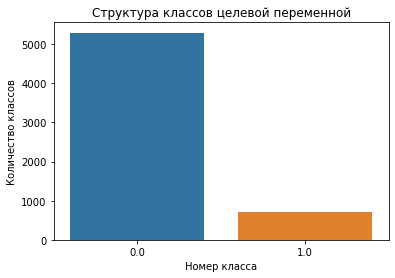

In [58]:
class_vc = df['blocked'].value_counts()
plot = sns.barplot(x = class_vc.index, y = class_vc)
plot.set_title('Структура классов целевой переменной')
plot.set_xlabel('Номер класса')
plot.set_ylabel('Количество классов');

In [59]:
df['blocked'].value_counts(normalize = True)

0.0    0.883511
1.0    0.116489
Name: blocked, dtype: float64

Оттоков у клиентов существенно меньше, присуствует умеренный дисбаланс классов.  
Вероятность оттока по train выборке 0.116489

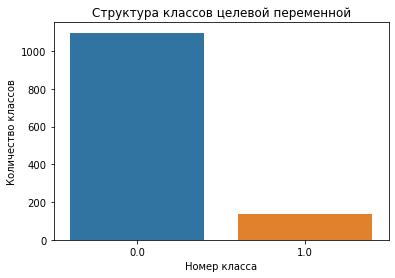

In [60]:
class_vc = df.loc[df['sleep'] == 1, 'blocked'].value_counts()
plot = sns.barplot(x = class_vc.index, y = class_vc)
plot.set_title('Структура классов целевой переменной')
plot.set_xlabel('Номер класса')
plot.set_ylabel('Количество классов');

In [61]:
df.loc[df['sleep'] == 1, 'blocked'].value_counts(normalize = True)

0.0    0.88835
1.0    0.11165
Name: blocked, dtype: float64

"Спящие" клиенты уходят примерно с такой же частотой

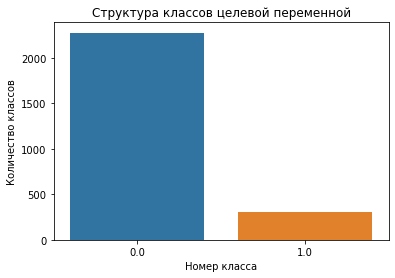

In [62]:
class_vc = df.loc[df['day_or_month_contract'] == 1,'blocked'].value_counts()
plot = sns.barplot(x = class_vc.index, y = class_vc)
plot.set_title('Структура классов целевой переменной')
plot.set_xlabel('Номер класса')
plot.set_ylabel('Количество классов');

In [63]:
df.loc[df['day_or_month_contract'] == 1,'blocked'].value_counts(normalize = True)

0.0    0.881192
1.0    0.118808
Name: blocked, dtype: float64

Типа контракта не влияет существенно на вероятность ухода.

# X_train, X_test, X_sub

Разделим данные на трейн, тест и часть для предсказаний.  
На трейне проведём отберём признаки, подберём гипперпараметры, проведём кросс-валидацию.  
На тесте проверим результат.
На части для предсказаний сделаем предсказание модели.  
Стратифицировать будем по признаку 'sleep', чтобы модель явно видела различия между клиентами.

In [64]:
features = df.columns.drop(['contract_id', 'blocked', 'test'])

# пропуски заменим медианой
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[df['test'] == 0, features].fillna(df[features].median()), 
    df.loc[df['test'] == 0, 'blocked'], 
    test_size= 0.1, 
    stratify = df.loc[df['test'] == 0, 'sleep'],
    random_state = random_state
)

X_predict_train = df.loc[df['test'] == 0, features].fillna(df[features].median())
y_predict_train = df.loc[df['test'] == 0, 'blocked']
X_predict_test = df.loc[df['test'] == 1, features].fillna(df[features].median())

# Feature selection

В качестве предиктора будем использовать алгоритм градиентного бустинга LightGBM.   
Его преимуществом является скорость базового алгоритма "из коробки" по сравнению с альтернативными алгоритмами град.бустинга.  
Отбирать признаки будем методом встроенного алгоритма LightGBM.  
При отборе признаков будем максимизацировать метрику f1.  
Несмотря на то, что итоговой оценкой модели обозначен recall,  
f1_score учитывает не только охват, но и точность модели.  
Если нам захочется в будущем увеличить recall, мы сможем сделать это  
передав модели вес классов.  
Т.к. присуствует дисбаланс классов изначально передадим модели  
параметр class_weight = 'balanced'

In [65]:
# доля отбрасываемых признаков
step = 0.1

# номера итераций
ps = range(0, 30)

# таблицы для сбора метрики на трейне и тесте
metric_fs_train = pd.DataFrame()
metric_fs_test = pd.DataFrame()

# сплиттер обучающей выборки для кросс-валидации
cv_splitter = StratifiedKFold(n_splits = 9,  shuffle = True, random_state = random_state)

target = 'blocked'

In [66]:
# предиктор и алгоритм отбора
cl = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    class_weight='balanced'
    )

#алгоритм отбора с ранжированием по 'gain'
lg_gain = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    importance_type = 'gain',
    class_weight='balanced'
    )

In [67]:
# до отбора
cv_res = cross_validate(
    cl, X_train[features], 
    y_train, 
    scoring= ['f1','recall', 'precision'], 
    n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True,
        verbose = 0
        )
print ('cv_f1 =', cv_res['test_f1'].mean())
print ('cv_precision =', cv_res['test_precision'].mean())
print ('cv_recall =', cv_res['test_recall'].mean())

cv_f1 = 0.4014107082895319
cv_precision = 0.3954404838571508
cv_recall = 0.41098323387325947


In [68]:
lgbm_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, cl, X_train, y_train, step, 
    ps, features, cv_splitter, metric_fs_train, 
    metric_fs_test, 'f1', 'lgbm'
    )

lgbm_gain_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, lg_gain, X_train, y_train,
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'f1', 'lgbm_gain'
    )

In [69]:
metric_fs_test.iloc[np.where(metric_fs_test == metric_fs_test.max().max())]

,14
lgbm,0.425358


In [70]:
metric_fs_test

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
lgbm,0.409904,0.418074,0.415961,0.424996,0.420727,0.418271,0.400562,0.395515,0.404237,0.404681,...,0.409482,0.416124,0.407835,0.405661,0.423100,0.404955,0.408863,0.410559,0.391644,0.377588
lgbm_gain,0.412949,0.420724,0.419786,0.406260,0.408820,0.408856,0.410336,0.412661,0.412973,0.412927,...,0.416492,0.404600,0.400735,0.402048,0.419264,0.382583,0.404337,0.401394,0.387046,0.391777


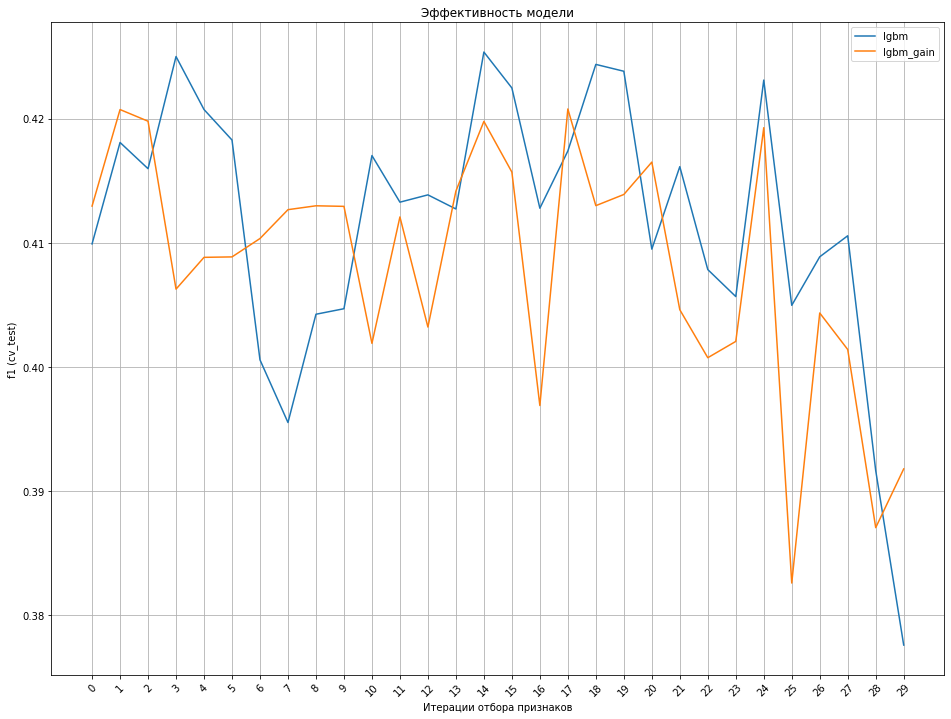

In [71]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_test.index:
    ax.plot(metric_fs_test.columns, metric_fs_test.loc[i, :], label=i)
ax.legend()
plt.title("Эффективность модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('f1 (cv_test)')
ax.grid(True)
plt.xticks(metric_fs_test.columns, rotation = 45)
plt.show()

In [72]:
new_feats = lgbm_feats[14]
new_feats

['lk sampo_mean',
 'fnc rt_max',
 'iptv_mean',
 'контактн_max',
 'broadcast sampo_sum',
 'платн_mean',
 'start sampo_mean',
 'st46 broadcast_max',
 'speedtest rt_mean',
 'гп_max',
 'st11 broadcast_mean',
 'истор_sum',
 'itv03 svc_mean',
 'ohrana sampo_mean',
 'смен_mean',
 'hosts ooklaserver_mean',
 'реестр_sum',
 'event_month_median',
 'pay sampo_mean',
 'интернет_sum',
 'st44 broadcast_mean',
 'ice sampo_max',
 'iptv rt_mean',
 'клиент_sum',
 'vitrina sampo_mean',
 'адрес_mean',
 'ivr_sum',
 'karelia rt_sum',
 'date_month_std',
 'скорост_mean',
 'договор_mean',
 'moigorod sampo_sum',
 'номер_mean',
 'интернет_mean',
 'static rt_mean',
 'изменен_sum',
 'контактн_mean',
 'date_day_of_the_week_median',
 'показ_mean',
 'турбокнопк_mean',
 'hosts ooklaserver_sum',
 'сутк_sum',
 'аренд_mean',
 'турбокнопк_sum',
 'rt static_mean',
 '20_sum',
 'просмотр_mean',
 'деньг_sum',
 'svc iptv_sum',
 'бесплатн_mean',
 'показ_sum',
 'data sampo_sum',
 'скидк_mean',
 'petrozavodsk speedtest_mean',
 'da

In [73]:
# после отбора
cv_res = cross_validate(
    cl, X_train[new_feats], 
    y_train, 
    scoring= ['f1','recall', 'precision'], 
    n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True,
        verbose = 0
        )
print ('cv_f1 =', cv_res['test_f1'].mean())
print ('cv_precision =', cv_res['test_precision'].mean())
print ('cv_recall =', cv_res['test_recall'].mean())

cv_f1 = 0.42535781590634236
cv_precision = 0.41736790117415395
cv_recall = 0.4368428530832623


Улучшили результат на кросс-валидации.  
Переберём небольшое количество гиперрпараметров.

In [74]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [7, 8, 9, 10, 11, -1]:
 for num_leaves in [19, 22, 25, 28, 31]:
        cl = LGBMClassifier(
            n_jobs = -1, 
            max_depth = max_depth,
            random_state = random_state,
            num_leaves = num_leaves,
            class_weight = 'balanced'
            )

        cv_res = cross_validate(
            cl, X_train[new_feats], 
            y_train, 
            scoring= ['f1','recall', 'precision'], 
            n_jobs = -1, 
            cv = cv_splitter, 
            return_train_score = True,
                verbose = 0
                )

        metric_table.loc[i, 'max_depth'] = max_depth
        metric_table.loc[i, 'num_leaves'] = num_leaves
        
        metric_table.loc[i, 'cv_train'] = cv_res['train_f1'].mean()
        metric_table.loc[i, 'cv_f1'] = cv_res['test_f1'].mean()
        metric_table.loc[i, 'cv_f1_std'] = cv_res['test_f1'].std()
        metric_table.loc[i, 'cv_precision'] = cv_res['test_precision'].mean()
        metric_table.loc[i, 'cv_recall'] = cv_res['test_recall'].mean()

        i+= 1

metric_table = metric_table.sort_values(by = 'cv_f1', ascending = False)
metric_table.head(10)

,max_depth,num_leaves,cv_train,cv_f1,cv_f1_std,cv_precision,cv_recall
7,8.0,25.0,0.681014,0.438975,0.032512,0.385342,0.513001
11,9.0,22.0,0.682383,0.436591,0.022062,0.383481,0.508052
13,9.0,28.0,0.715042,0.435873,0.025417,0.397473,0.485365
5,8.0,19.0,0.648501,0.435750,0.026525,0.374019,0.524249
20,11.0,19.0,0.671455,0.435450,0.025779,0.379551,0.512977
16,10.0,22.0,0.692783,0.435449,0.030405,0.388755,0.498461
0,7.0,19.0,0.637790,0.432405,0.020609,0.367473,0.527541
2,7.0,25.0,0.657349,0.432317,0.023816,0.369033,0.522615
1,7.0,22.0,0.648443,0.432296,0.019283,0.366416,0.529080
9,8.0,31.0,0.701652,0.431458,0.021451,0.385153,0.491925


Наш результат f1 на кросс - валидации = 0.438975  
Гиперпараметры:  
max_depth = 8,  
num_leaves = 25,  
class_weight = 	'balanced',  

# H-out

In [75]:
cl = LGBMClassifier(
    n_jobs = -1, 
    max_depth = 8,
    random_state = random_state,
    num_leaves = 25,
    class_weight = 	'balanced',
    )

cl.fit(X_train[new_feats], y_train)

LGBMClassifier(class_weight='balanced', max_depth=8, num_leaves=25,
               random_state=142)

In [76]:
predict = cl.predict(X_test[new_feats])

In [77]:
recall_score(y_test, predict)

0.5

In [78]:
f1_score(y_test, predict)

0.49382716049382713

In [79]:
precision_score(y_test, predict)

0.4878048780487805

Recall близок к значениям на кросс-валидации. Precision повыше.
Результаты приемлимые.

<AxesSubplot:ylabel='Count'>

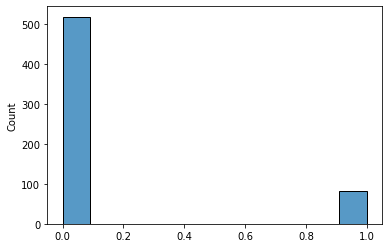

In [80]:
sns.histplot(predict)

In [81]:
cl.fit(X_train[new_feats], y_train)

imp = pd.Series(
    data = cl.feature_importances_,
    index = new_feats
).sort_values(ascending = False)

imp.head(25)

unixtimestamp_max             138
unixtimestamp_mean             87
unixtimestamp_std              84
unixtimestamp_min              72
event_day_mean                 70
unixtimestamp_median           62
date_unixtimestamp_max         56
event_day_of_the_week_mean     53
event_day_max                  51
event_day_of_the_week_std      46
event_day_std                  40
ice sampo_mean                 37
date_unixtimestamp_mean        35
unixtimestamp_nunique          35
event_day_min                  35
date_day_max                   33
date_unixtimestamp_std         32
event_day_median               32
date_day_of_the_week_std       31
fnc rt_mean                    30
date_day_std                   28
event_month_mean               28
day_or_month_contract          26
услуг_mean                     25
event_month_std                25
dtype: int32

Нет признаков, которые могли бы дать утечку данных.

# Predict

In [82]:
cl.fit(X_predict_train[new_feats], y_predict_train)
predict = cl.predict(X_predict_test[new_feats])

In [83]:
sample_solution['blocked'] = predict

In [84]:
# sample_solution.to_csv('data/solution.csv', index = False)

In [86]:
# solution = pd.read_csv('data/solution.csv')

# Выводы и итоги

Что сделано:
1. Загрузили данные.
2. Создали новые признаки.
3. Сформировали дадасет для обучения, теста и предсказания.
4. Выбрали метрику для оценки модели (f1-score, recall)
5. Провели отбор признаков.
6. Провели подбор гипперпараметров.
7. Провели кросс-валидацию.
8. Провели тестирование на отложенной выборке.
9. Сделали предсказание.

Итоги:  
Удалось создать модель предсказания оттока клиента по истории его обращений и логам запросов к сторонним сайтам.  
Существенная часть клиентов не проявляли активности и информации по ним никакой нет, кроме базовой вероятности оттока по выборке  
и типа подписки, поэтому кросс-валидационные фолды формировались стратифицированными по активным/неактивным клиентам,  
чтобы алгоритм мог учесть это.  
Присуствует дисбаланс выборки, поэтому изначально в модель LightGBM передан параметр class_weight = 'balanced'.  
Для повышения метрики f1-score на текущих данных можно:
- провести дополнительный EDA и создать новые признаки 
- протестировать другие алгоритмы и/или их композиции
- провести более глубокий подбор гиперпараметров   

Для повышения метрики recall можно провести дополнительный подбор весов классов, отталкиваясь от бизнес задачи и  
лучшего компромисса между precision и recall.